<a href="https://colab.research.google.com/github/yasinsoylu1997/224-224-undersampling/blob/main/ResNet50_models_224_224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras


In [3]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [4]:
X = []
y = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:04<00:00, 271.52it/s]


In [5]:
from imblearn.under_sampling import RandomUnderSampler 

reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomUnderSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
new_X = oversampled_X.reshape(-1,224,224,3)
oversampled_y

array(['COVID', 'COVID', 'COVID', ..., 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia'], dtype='<U15')

In [6]:
train_images, test_images,train_labels, test_labels = train_test_split(new_X , oversampled_y , test_size=0.25, random_state=42,shuffle=True)

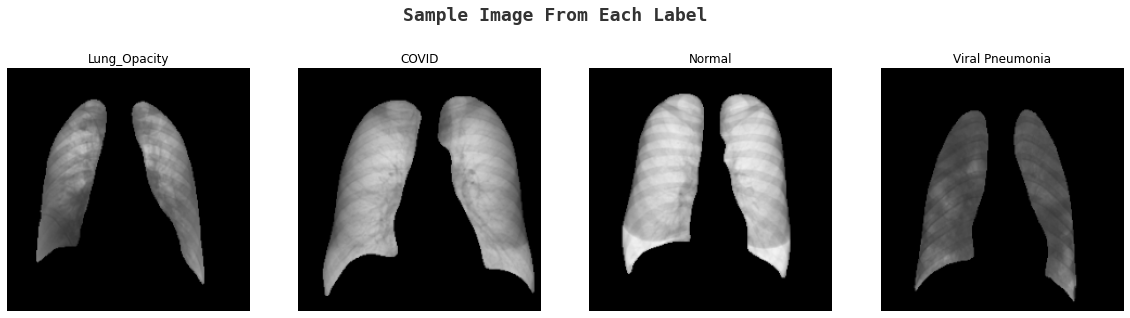

In [7]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y[j]==i:
            ax[k].imshow(X[j])
            ax[k].set_title(y[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

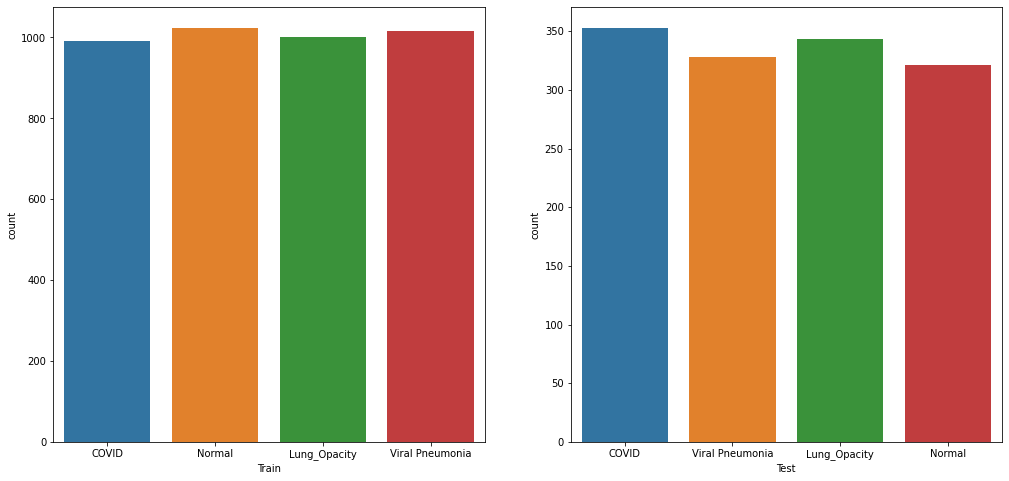

In [8]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [9]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [11]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [12]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [13]:
#Load model wothout classifier/fully connected layers
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in ResNet50_model.layers:
	layer.trainable = False
    
ResNet50_model.summary()  #Trainable parameters will be 0

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [14]:
#Now, let us use features from convolutional network for RF
feature_extractor=ResNet50_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_model= features #This is our X input for model

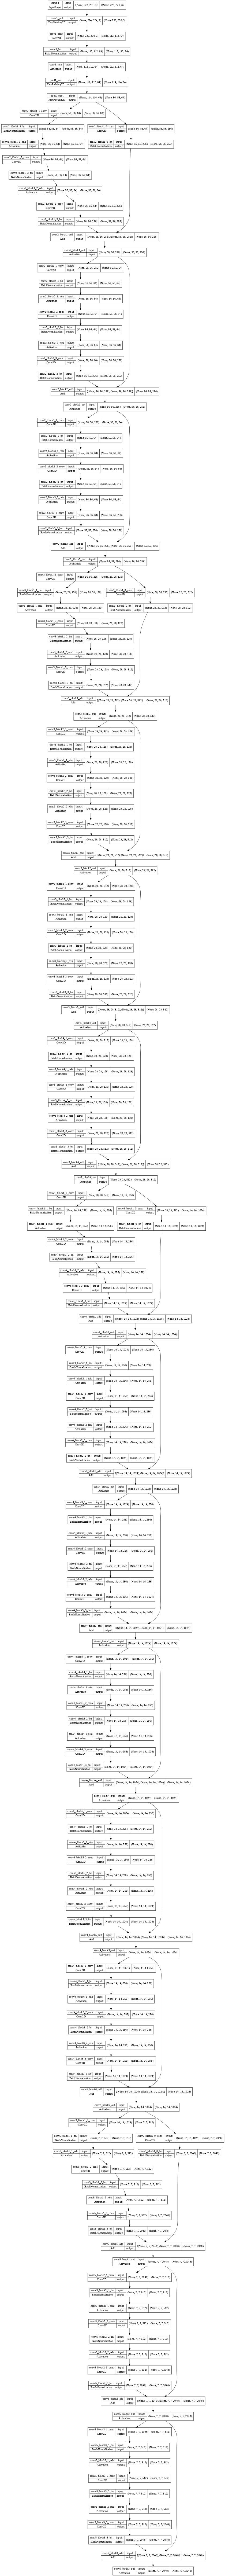

In [15]:
from keras.utils.vis_utils import plot_model

plot_model(ResNet50_model, to_file='model_plot_ResNet50_224.png', show_shapes=True, show_layer_names=True,dpi=50)

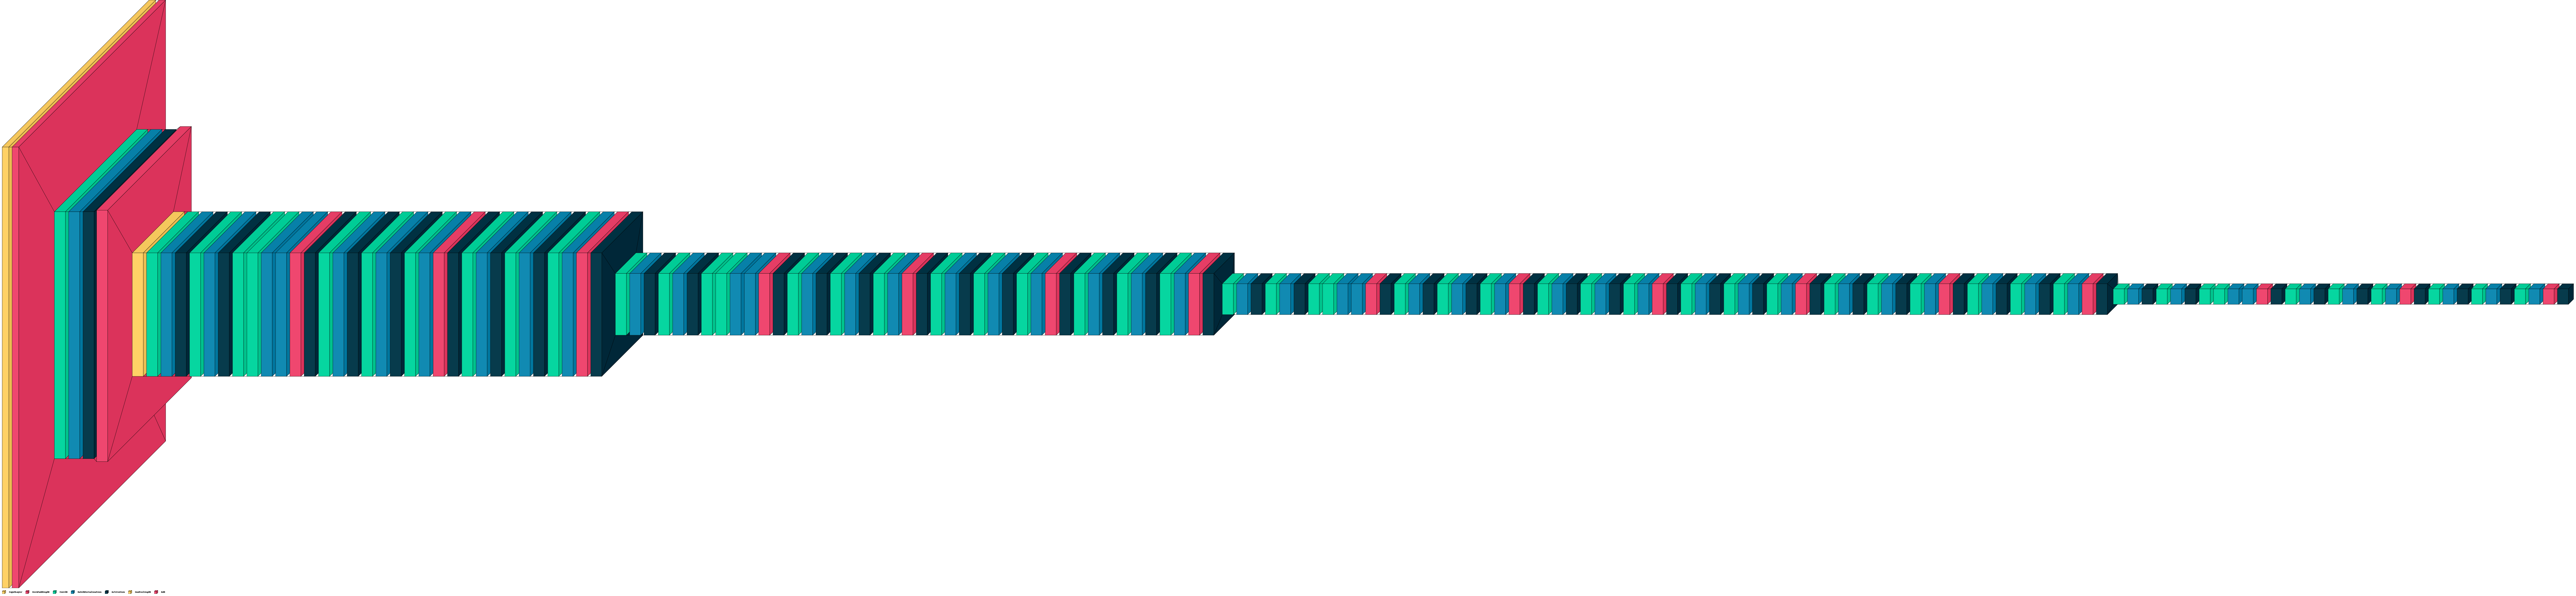

<Figure size 144x144 with 0 Axes>

In [16]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(ResNet50_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [17]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

# knn

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [19]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = knn_model.predict(X_test_features)

In [20]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.39330855018587363
MSE: 0.6148698884758365
RMSE: 0.7841363966019155
R2 Square 0.5125261088424284
Accuracy 0.7100371747211895
__________________________________


In [21]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, prediction) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.393309,0.61487,0.784136,0.512526,0.710037


In [22]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.60      0.61      0.61       353
           1       0.65      0.59      0.62       343
           2       0.67      0.73      0.70       321
           3       0.93      0.92      0.92       328

    accuracy                           0.71      1345
   macro avg       0.71      0.71      0.71      1345
weighted avg       0.71      0.71      0.71      1345



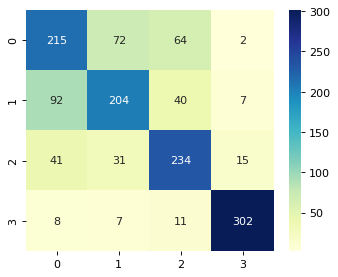

In [23]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [24]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [25]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = cart_model.predict(X_test_features)

In [26]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.5739776951672863
MSE: 0.9680297397769517
RMSE: 0.9838850236572115
R2 Square 0.23253808187768055
Accuracy 0.5962825278810409
__________________________________


In [27]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.393309,0.61487,0.784136,0.512526,0.710037
1,DecisionTreeClassifier,0.573978,0.96803,0.983885,0.232538,0.596283


In [28]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.51      0.47      0.49       353
           1       0.52      0.54      0.53       343
           2       0.55      0.59      0.57       321
           3       0.82      0.80      0.81       328

    accuracy                           0.60      1345
   macro avg       0.60      0.60      0.60      1345
weighted avg       0.60      0.60      0.60      1345



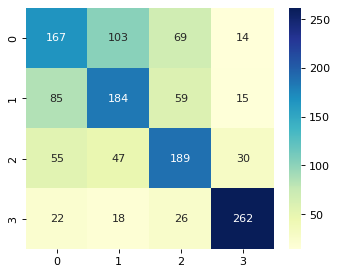

In [29]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [30]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [31]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = lr_model.predict(X_test_features)

In [32]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.34572490706319703
MSE: 0.5449814126394052
RMSE: 0.7382285639552328
R2 Square 0.5679342657575575
Accuracy 0.7486988847583643
__________________________________


In [33]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.393309,0.614870,0.784136,0.512526,0.710037
1,DecisionTreeClassifier,0.573978,0.968030,0.983885,0.232538,0.596283
2,LogisticRegression,0.345725,0.544981,0.738229,0.567934,0.748699


In [34]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       353
           1       0.70      0.73      0.71       343
           2       0.70      0.75      0.72       321
           3       0.93      0.93      0.93       328

    accuracy                           0.75      1345
   macro avg       0.75      0.75      0.75      1345
weighted avg       0.75      0.75      0.75      1345



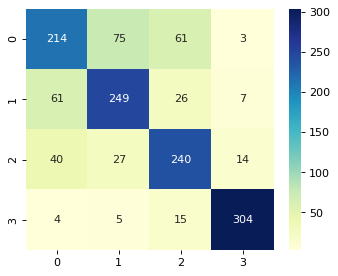

In [35]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [36]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [37]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = LGBM_model.predict(X_test_features)

In [38]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.29442379182156136
MSE: 0.441635687732342
RMSE: 0.664556760354104
R2 Square 0.6498676041746101
Accuracy 0.774721189591078
__________________________________


In [39]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.393309,0.614870,0.784136,0.512526,0.710037
1,DecisionTreeClassifier,0.573978,0.968030,0.983885,0.232538,0.596283
2,LogisticRegression,0.345725,0.544981,0.738229,0.567934,0.748699
3,LGBMClassifier,0.294424,0.441636,0.664557,0.649868,0.774721


In [40]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.72      0.67      0.69       353
           1       0.70      0.71      0.71       343
           2       0.75      0.79      0.77       321
           3       0.94      0.94      0.94       328

    accuracy                           0.77      1345
   macro avg       0.78      0.78      0.78      1345
weighted avg       0.77      0.77      0.77      1345



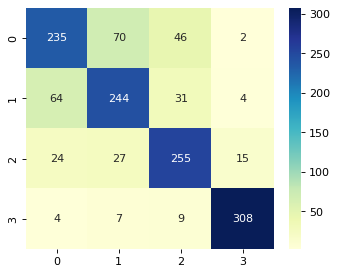

In [41]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [43]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = rf_model.predict(X_test_features)

In [44]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3643122676579926
MSE: 0.5888475836431227
RMSE: 0.7673640489644552
R2 Square 0.5331568055661466
Accuracy 0.7368029739776951
__________________________________


In [45]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.393309,0.614870,0.784136,0.512526,0.710037
1,DecisionTreeClassifier,0.573978,0.968030,0.983885,0.232538,0.596283
2,LogisticRegression,0.345725,0.544981,0.738229,0.567934,0.748699
3,LGBMClassifier,0.294424,0.441636,0.664557,0.649868,0.774721
4,RandomForestClassifier,0.364312,0.588848,0.767364,0.533157,0.736803


In [46]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       353
           1       0.68      0.66      0.67       343
           2       0.70      0.74      0.72       321
           3       0.91      0.92      0.91       328

    accuracy                           0.74      1345
   macro avg       0.74      0.74      0.74      1345
weighted avg       0.74      0.74      0.74      1345



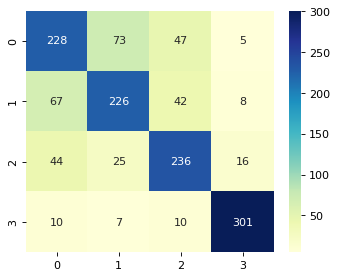

In [47]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [48]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [49]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GB_model.predict(X_test_features)

In [50]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.6691449814126395
MSE: 1.0200743494423792
RMSE: 1.009987301624322
R2 Square 0.19127668843024404
Accuracy 0.4899628252788104
__________________________________


In [51]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.393309,0.614870,0.784136,0.512526,0.710037
1,DecisionTreeClassifier,0.573978,0.968030,0.983885,0.232538,0.596283
2,LogisticRegression,0.345725,0.544981,0.738229,0.567934,0.748699
3,LGBMClassifier,0.294424,0.441636,0.664557,0.649868,0.774721
4,RandomForestClassifier,0.364312,0.588848,0.767364,0.533157,0.736803
5,GaussianNB,0.669145,1.020074,1.009987,0.191277,0.489963


In [52]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.48      0.14      0.21       353
           1       0.39      0.77      0.52       343
           2       0.51      0.62      0.56       321
           3       0.84      0.45      0.59       328

    accuracy                           0.49      1345
   macro avg       0.55      0.49      0.47      1345
weighted avg       0.55      0.49      0.46      1345



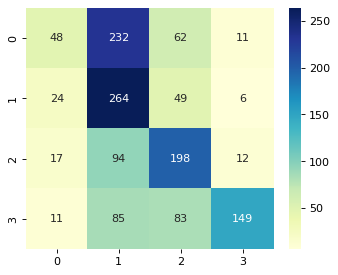

In [53]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [54]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [55]:
X_test_feature =ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = SGD_model.predict(X_test_features)

In [56]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.44758364312267657
MSE: 0.7197026022304833
RMSE: 0.848352876007669
R2 Square 0.4294138734697349
Accuracy 0.6825278810408922
__________________________________


In [57]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.393309,0.614870,0.784136,0.512526,0.710037
1,DecisionTreeClassifier,0.573978,0.968030,0.983885,0.232538,0.596283
2,LogisticRegression,0.345725,0.544981,0.738229,0.567934,0.748699
3,LGBMClassifier,0.294424,0.441636,0.664557,0.649868,0.774721
4,RandomForestClassifier,0.364312,0.588848,0.767364,0.533157,0.736803
5,GaussianNB,0.669145,1.020074,1.009987,0.191277,0.489963
6,SGDClassifier,0.447584,0.719703,0.848353,0.429414,0.682528


In [58]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.69      0.52      0.60       353
           1       0.88      0.43      0.58       343
           2       0.49      0.95      0.65       321
           3       0.96      0.85      0.90       328

    accuracy                           0.68      1345
   macro avg       0.76      0.69      0.68      1345
weighted avg       0.76      0.68      0.68      1345



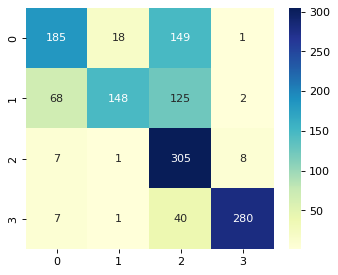

In [59]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SVC

In [60]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [61]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svm_model.predict(X_test_features)

In [62]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.32118959107806694
MSE: 0.49516728624535317
RMSE: 0.7036812390886609
R2 Square 0.6074273137715325
Accuracy 0.762825278810409
__________________________________


In [63]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.393309,0.614870,0.784136,0.512526,0.710037
1,DecisionTreeClassifier,0.573978,0.968030,0.983885,0.232538,0.596283
2,LogisticRegression,0.345725,0.544981,0.738229,0.567934,0.748699
3,LGBMClassifier,0.294424,0.441636,0.664557,0.649868,0.774721
4,RandomForestClassifier,0.364312,0.588848,0.767364,0.533157,0.736803
5,GaussianNB,0.669145,1.020074,1.009987,0.191277,0.489963
6,SGDClassifier,0.447584,0.719703,0.848353,0.429414,0.682528
7,SVC,0.321190,0.495167,0.703681,0.607427,0.762825


In [64]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       353
           1       0.70      0.69      0.70       343
           2       0.73      0.71      0.72       321
           3       0.95      0.92      0.94       328

    accuracy                           0.76      1345
   macro avg       0.77      0.76      0.77      1345
weighted avg       0.77      0.76      0.76      1345



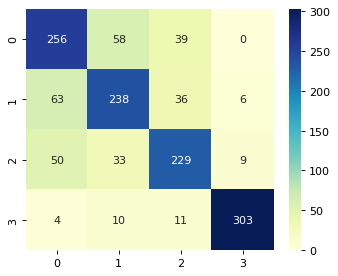

In [65]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [66]:
modeller = [rf_model,GB_model,LGBM_model,SGD_model,lr_model,cart_model,svm_model,knn_model]


In [72]:
sonuc = []
from sklearn.metrics import accuracy_score

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy_ResNet50"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_features)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy_ResNet50"])
    sonuclar = sonuclar.append(sonuc)
    

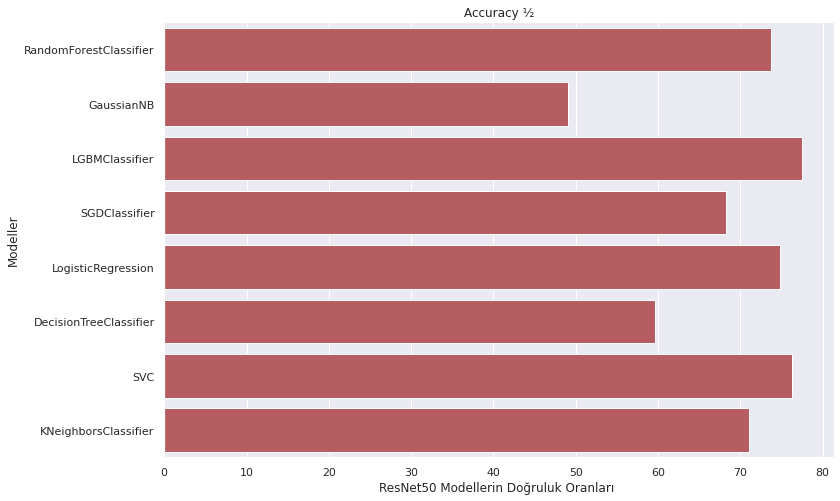

In [74]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x= 'Accuracy_ResNet50', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('ResNet50 Modellerin Doğruluk Oranları ')
plt.title('Accuracy ½'); 

In [76]:
best_acc=sonuclar.sort_values(by=['Accuracy_ResNet50'], ascending=False)
en_iyi_model_my_model=best_acc[:1]
en_iyi_model_my_model

,Modeller,Accuracy_ResNet50
0,LGBMClassifier,77.472119


In [77]:
results_df


,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.393309,0.614870,0.784136,0.512526,0.710037
1,DecisionTreeClassifier,0.573978,0.968030,0.983885,0.232538,0.596283
2,LogisticRegression,0.345725,0.544981,0.738229,0.567934,0.748699
3,LGBMClassifier,0.294424,0.441636,0.664557,0.649868,0.774721
4,RandomForestClassifier,0.364312,0.588848,0.767364,0.533157,0.736803
5,GaussianNB,0.669145,1.020074,1.009987,0.191277,0.489963
6,SGDClassifier,0.447584,0.719703,0.848353,0.429414,0.682528
7,SVC,0.321190,0.495167,0.703681,0.607427,0.762825


In [78]:
from google.colab import files

results_df.to_csv('output_resnet50_224.csv', encoding = 'utf-8-sig') 
files.download('output_resnet50_224.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>